In [18]:
# ===== LIBRARY IMPORTS =====
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# External package setup
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# Data source
import yfinance as yf

# Time series analysis
from statsmodels.tsa.stattools import acf

# JAX ecosystem
import jax
import jax.numpy as jnp
import jax.lax as lax

# NumPyro for Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

# Particles package
import particles
from particles import state_space_models as ssm
from particles import mcmc, distributions
from particles.collectors import Moments
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap

print("All libraries imported successfully")
print(f"NumPyro version: {numpyro.__version__}")
print(f"JAX version: {jax.__version__}")

All libraries imported successfully
NumPyro version: 0.18.0
JAX version: 0.4.30


## 1. Data Collection and Preprocessing

### Fetch S&P 500 and NASDAQ Returns
Download financial data and compute log returns for the joint volatility analysis.

In [19]:
def fetch_spy_eem_data(start_date="2022-01-01", end_date="2025-01-01"):
    """
    Fetch SPY (S&P 500) and EEM (Emerging Markets) data and compute log returns.
    
    Returns:
        tuple: (returns_df, returns_array) - DataFrame and numpy array of returns
    """
    # Download data
    tickers = ["SPY", "EEM"]  # S&P 500 ETF and Emerging Markets ETF
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
    # Extract closing prices and compute log returns (in %)
    spy_close = data['Close']['SPY']
    eem_close = data['Close']['EEM']
    
    spy_returns = np.log(spy_close / spy_close.shift(1)) * 100
    eem_returns = np.log(eem_close / eem_close.shift(1)) * 100
    
    # Create DataFrame and remove NaNs
    returns_df = pd.DataFrame({
        'SPY': spy_returns,
        'EEM': eem_returns
    }).dropna()
    
    returns_array = returns_df.values
    
    # Summary statistics
    print(f"📊 Data Summary ({len(returns_df)} trading days):")
    print(f"   Period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"   SPY:  μ={returns_df['SPY'].mean():.3f}%, σ={returns_df['SPY'].std():.2f}%")
    print(f"   EEM:  μ={returns_df['EEM'].mean():.3f}%, σ={returns_df['EEM'].std():.2f}%")
    print(f"   Correlation: ρ={returns_df['SPY'].corr(returns_df['EEM']):.3f}")
    
    # Data quality check
    if returns_df.isnull().any().any():
        n_nans = returns_df.isnull().sum().sum()
        print(f"⚠️  Warning: Removed {n_nans} NaN values")
        returns_df = returns_df.dropna()
        returns_array = returns_df.values
    
    print(f"✅ Returns array shape: {returns_array.shape}")
    return returns_df, returns_array

# Fetch the data
returns_df, returns_array = fetch_spy_eem_data()

📊 Data Summary (752 trading days):
   Period: 2022-01-04 to 2024-12-31
   SPY:  μ=0.033%, σ=1.10%
   EEM:  μ=-0.012%, σ=1.17%
   Correlation: ρ=0.674
✅ Returns array shape: (752, 2)


### Data Visualization and Exploratory Analysis

Comprehensive visualization of the bivariate return series to understand volatility clustering, correlation structure, and distributional properties.

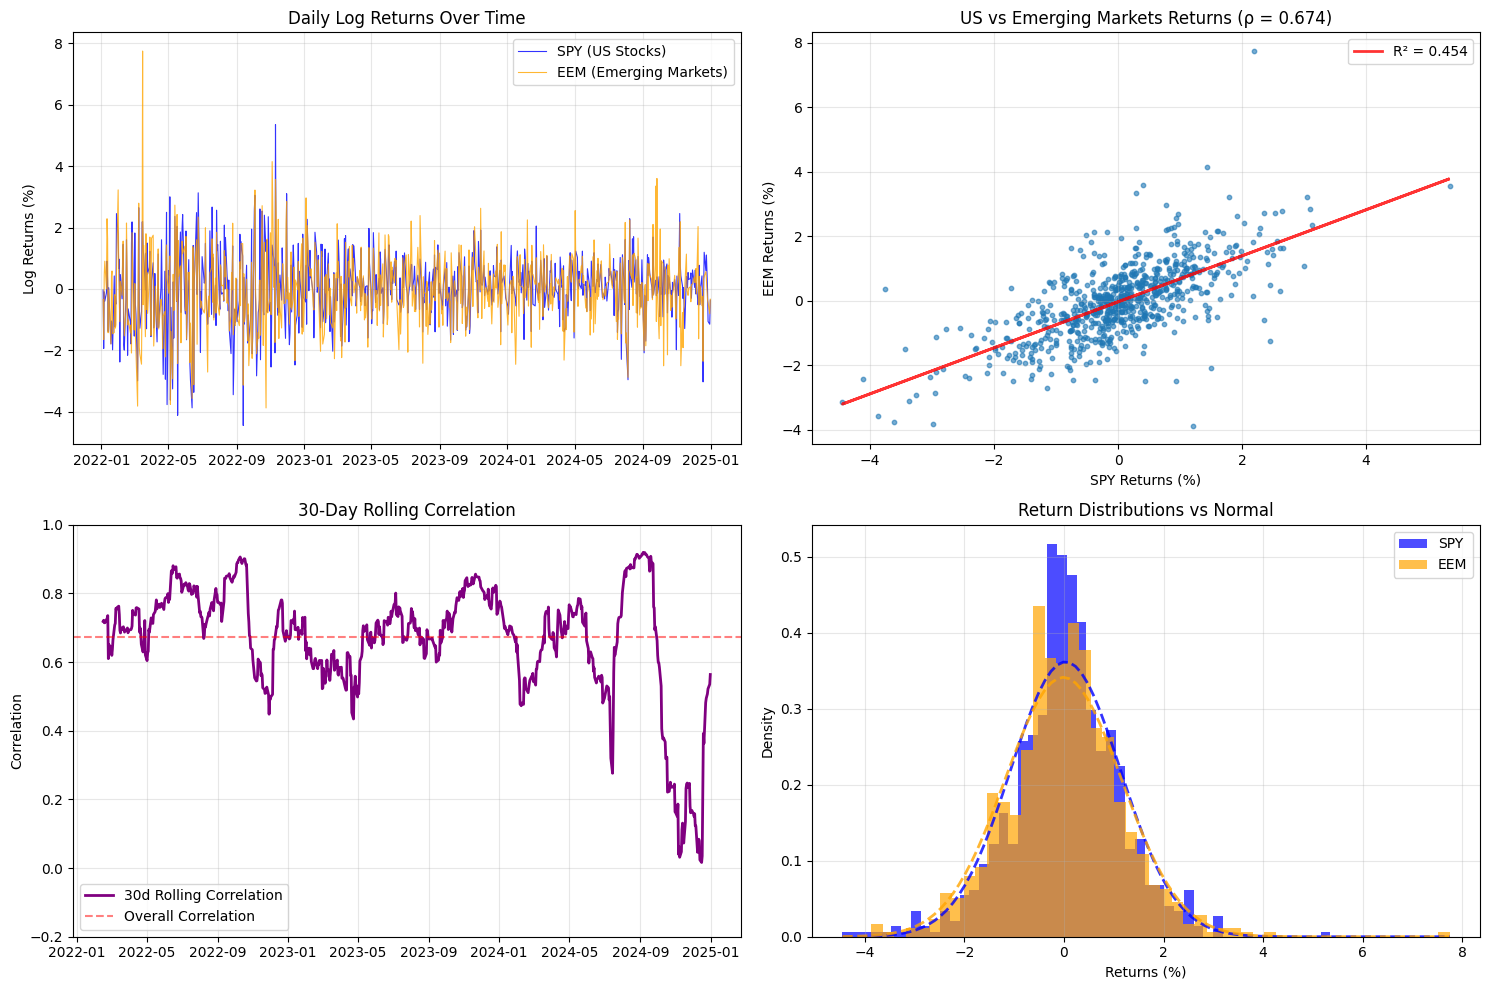

📊 DETAILED DATA SUMMARY
Period: 2022-01-04 to 2024-12-31
Observations: 752 trading days

DESCRIPTIVE STATISTICS:
  SPY: μ= 0.033%, σ= 1.10%, Skew=-0.224, Kurt= 1.812
  EEM: μ=-0.012%, σ= 1.17%, Skew= 0.388, Kurt= 2.914

CORRELATION & VOLATILITY:
  Overall Correlation: 0.6736
  Correlation Range: [0.016, 0.920]
  Annualized volatility - SPY: 17.52%, EEM: 18.56%

EXTREME EVENTS (1% tails):
  SPY: worst < -3.14% (8 days), best > 2.61% (8 days)
  EEM: worst < -2.79% (8 days), best > 2.91% (8 days)


In [20]:
def plot_spy_eem_overview(returns_df):
    """Create comprehensive overview plots of SPY and EEM data."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Time series of returns
    ax1 = axes[0, 0]
    ax1.plot(returns_df.index, returns_df['SPY'], label='SPY (US Stocks)', alpha=0.8, linewidth=0.8, color='blue')
    ax1.plot(returns_df.index, returns_df['EEM'], label='EEM (Emerging Markets)', alpha=0.8, linewidth=0.8, color='orange')
    ax1.set_title('Daily Log Returns Over Time')
    ax1.set_ylabel('Log Returns (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot with regression line
    ax2 = axes[0, 1]
    ax2.scatter(returns_df['SPY'], returns_df['EEM'], alpha=0.6, s=10)
    correlation = returns_df["SPY"].corr(returns_df["EEM"])
    
    # Add regression line
    slope, intercept, r_value, _, _ = stats.linregress(returns_df['SPY'], returns_df['EEM'])
    line = slope * returns_df['SPY'] + intercept
    ax2.plot(returns_df['SPY'], line, 'r-', alpha=0.8, linewidth=2, label=f'R² = {r_value**2:.3f}')
    ax2.set_xlabel('SPY Returns (%)')
    ax2.set_ylabel('EEM Returns (%)')
    ax2.set_title(f'US vs Emerging Markets Returns (ρ = {correlation:.3f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Rolling correlation (30-day window)
    ax3 = axes[1, 0]
    window = 30
    rolling_corr = returns_df['SPY'].rolling(window=window).corr(returns_df['EEM'])
    
    ax3.plot(returns_df.index, rolling_corr, label=f'{window}d Rolling Correlation', linewidth=2, color='purple')
    ax3.axhline(y=correlation, color='red', linestyle='--', alpha=0.5, label='Overall Correlation')
    ax3.set_title(f'{window}-Day Rolling Correlation')
    ax3.set_ylabel('Correlation')
    ax3.set_ylim(-0.2, 1)  # Adjusted for typical range of this pair
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution comparison
    ax4 = axes[1, 1]
    ax4.hist(returns_df['SPY'], bins=50, alpha=0.7, label='SPY', density=True, color='blue')
    ax4.hist(returns_df['EEM'], bins=50, alpha=0.7, label='EEM', density=True, color='orange')
    
    # Normal distribution overlays
    x_range = np.linspace(min(returns_df['SPY'].min(), returns_df['EEM'].min()),
                         max(returns_df['SPY'].max(), returns_df['EEM'].max()), 100)
    
    for col, color, style in [('SPY', 'blue', '--'), ('EEM', 'orange', '--')]:
        normal_dist = stats.norm.pdf(x_range, returns_df[col].mean(), returns_df[col].std())
        ax4.plot(x_range, normal_dist, color=color, linestyle=style, alpha=0.8, linewidth=2)
    
    ax4.set_xlabel('Returns (%)')
    ax4.set_ylabel('Density')
    ax4.set_title('Return Distributions vs Normal')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("📊 DETAILED DATA SUMMARY")
    print("=" * 50)
    print(f"Period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"Observations: {len(returns_df)} trading days")
    
    print("\nDESCRIPTIVE STATISTICS:")
    for col in ['SPY', 'EEM']:
        data = returns_df[col]
        print(f"  {col:>3}: μ={data.mean():6.3f}%, σ={data.std():5.2f}%, "
              f"Skew={data.skew():6.3f}, Kurt={data.kurtosis():6.3f}")
    
    print(f"\nCORRELATION & VOLATILITY:")
    print(f"  Overall Correlation: {correlation:.4f}")
    print(f"  Correlation Range: [{rolling_corr.min():.3f}, {rolling_corr.max():.3f}]")
    spy_ann = returns_df['SPY'].std() * np.sqrt(252)
    eem_ann = returns_df['EEM'].std() * np.sqrt(252)
    print(f"  Annualized volatility - SPY: {spy_ann:.2f}%, EEM: {eem_ann:.2f}%")
    
    print(f"\nEXTREME EVENTS (1% tails):")
    for col in ['SPY', 'EEM']:
        data = returns_df[col]
        q01, q99 = data.quantile([0.01, 0.99])
        extreme_down = (data <= q01).sum()
        extreme_up = (data >= q99).sum()
        print(f"  {col:>3}: worst < {q01:.2f}% ({extreme_down} days), "
              f"best > {q99:.2f}% ({extreme_up} days)")

# Create the visualization
plot_spy_eem_overview(returns_df)

### Train/Test Split

Split the data into training and testing sets for out-of-sample model evaluation.

In [21]:
def split_data_2d(returns_df, returns_array, train_ratio=0.8):
    """Split 2D data into training and testing sets."""
    n_total = len(returns_df)
    n_train = int(n_total * train_ratio)
    
    # Split data
    train_df = returns_df.iloc[:n_train].copy()
    test_df = returns_df.iloc[n_train:].copy()
    train_array = returns_array[:n_train]
    test_array = returns_array[n_train:]
    
    print(f"📊 Data Split Summary:")
    print(f"   Training: {len(train_df)} days ({train_df.index[0].date()} to {train_df.index[-1].date()})")
    print(f"   Testing:  {len(test_df)} days ({test_df.index[0].date()} to {test_df.index[-1].date()})")
    print(f"   Training correlation: {train_df['SPY'].corr(train_df['EEM']):.3f}")
    print(f"   Testing correlation:  {test_df['SPY'].corr(test_df['EEM']):.3f}")
    print(f"   Array shapes: Train{train_array.shape}, Test{test_array.shape}")
    
    return train_df, test_df, train_array, test_array

# Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# Store individual series for convenience
spy_train, eem_train = train_df['SPY'].values, train_df['EEM'].values
spy_test, eem_test = test_df['SPY'].values, test_df['EEM'].values

print("✅ Data split completed successfully")

📊 Data Split Summary:
   Training: 601 days (2022-01-04 to 2024-05-24)
   Testing:  151 days (2024-05-28 to 2024-12-31)
   Training correlation: 0.695
   Testing correlation:  0.551
   Array shapes: Train(601, 2), Test(151, 2)
✅ Data split completed successfully


In [22]:
class AFactorMSV(ssms.StateSpaceModel):
    
    # Fitted parameters from the paper of Yu and Meyer (2006)
    default_params = {'mu':-2.0, 'phi': 0.9942, 'sigma': 0.1055, 
                      'sigma_e_1': 0.6799, 'sigma_e_2': 0.2087, 'd': 1.233}
    
    def PX0(self):
        """Law of X_0 at time 0: stationary distribution"""
        h_0_loc = self.mu
        h_0_scale = self.sigma / np.sqrt(1 - self.phi**2) 
        joint_dist = OrderedDict()
        joint_dist['h'] = dists.Normal(loc=h_0_loc, scale=h_0_scale)
        # Initial f_0 has volatility exp(h_0/2)
        joint_dist['f'] = dists.Cond(lambda x: dists.Normal(loc=0., scale=np.exp(x['h']/2)))
        px0_dist = dists.StructDist(joint_dist)
        return px0_dist

    def PX(self, t, xp):
        """Conditional distribution of X_t, given the previous state."""
        # h_t follows AR(1)
        h_t_loc = self.mu + self.phi * (xp['h'] - self.mu)
        h_t_scale = self.sigma
        joint_dist = OrderedDict()
        joint_dist['h'] = dists.Normal(loc=h_t_loc, scale=h_t_scale)
        # f_t is new each period with volatility exp(h_t/2)
        joint_dist['f'] = dists.Cond(lambda x: dists.Normal(loc=0., scale=np.exp(x['h']/2)))
        px_dist = dists.StructDist(joint_dist)
        return px_dist

    def PY(self, t, xp, x):
        """Conditional distribution of Y_t, given X_t"""
        # Y_t = D * f_t + e_t where D = [1, d]'
        # So y1_t = f_t + e1_t and y2_t = d * f_t + e2_t
        f_t = x['f']
        y_t_loc = np.stack([f_t, self.d * f_t], axis=1)  # Shape: (N, 2)
        y_t_cov = np.diag([self.sigma_e_1 ** 2, self.sigma_e_2 ** 2])
        return dists.MvNormal(loc=y_t_loc, cov=y_t_cov)

### Baseline Model: Bivariate Normal

Simple constant covariance model for comparison (equivalent to 2D Black-Scholes assumption).

In [23]:
class BivariateNormal(ssm.StateSpaceModel):
    """Simple constant bivariate normal model (2D Black-Scholes equivalent)"""
    
    def __init__(self, data):
        self.data = np.array(data)
        self.mean = np.mean(self.data, axis=0)  # Should be close to [0, 0]
        self.cov = np.cov(self.data.T) + 1e-6 * np.eye(2)  # Add regularization
    
    def PX0(self):
        """Dummy initial state"""
        return distributions.MvNormal(loc=np.zeros(2), cov=0.001 * np.eye(2))
    
    def PX(self, t, xp):
        """Dummy state transition"""
        return distributions.MvNormal(loc=xp, cov=0.0001 * np.eye(2))
    
    def PY(self, t, xp, x):
        """Observation model: Y_t ~ N(μ, Σ) with constant parameters"""
        N = len(x)
        
        class ConstantBivariateNormal:
            def __init__(self, mean, cov, N):
                self.mean, self.cov, self.N = mean, cov, N
            
            def logpdf(self, y):
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)
                
                diff = y[0] - self.mean
                det_cov = np.linalg.det(self.cov)
                
                if det_cov <= 0:
                    return np.full(self.N, -np.inf)
                
                inv_cov = np.linalg.inv(self.cov)
                exponent = -0.5 * diff @ inv_cov @ diff.T
                normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                return np.full(self.N, exponent + normalization)
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                return np.random.multivariate_normal(self.mean, self.cov, size)
        
        return ConstantBivariateNormal(self.mean, self.cov, N)

## 3. Bayesian Parameter Estimation

### HMC/NUTS Estimation with NumPyro

Efficient Bayesian estimation using Hamiltonian Monte Carlo with non-centered parameterization for improved sampling efficiency.

In [75]:
def numpyro_estimation_afactor_msv(returns_array, n_iter=10000, n_warmup=2000, n_chains=2):
    """
    HMC estimation for AFactorMSV model using non-centered parameterization.
    
    Args:
        returns_array: (T, 2) array of returns
        n_iter: Total iterations per chain
        n_warmup: Warmup iterations
        n_chains: Number of parallel chains
    
    Returns:
        dict: MCMC results and parameter estimates
    """
    jax.config.update("jax_platform_name", "cpu")
    T, _ = returns_array.shape
    y_data = jnp.array(returns_array)
    
    def afactor_msv_model(y=None):
        # Prior distributions (based on Yu and Meyer 2006 defaults)
        y_mean = jnp.mean(jnp.log(jnp.var(y_data, axis=0) + 1e-6))  
        mu = numpyro.sample('mu', dist.Normal(y_mean, 1.))
        phi_raw = numpyro.sample('phi_raw', dist.Beta(20., 1.5))
        phi = 2. * phi_raw - 1.
        numpyro.deterministic('phi', phi)
        sigma = numpyro.sample('sigma', dist.Exponential(1.))
        sigma_e_1 = numpyro.sample('sigma_e_1', dist.InverseGamma(3., 1.4))
        sigma_e_2 = numpyro.sample('sigma_e_2', dist.InverseGamma(3., 0.4))
        d = numpyro.sample('d', dist.HalfNormal(5.))
        
        # Stationary variance for initial state
        var_h = sigma**2 / (1 - phi**2 + 1e-6)
        
        # Non-centered initial state for h
        h_0_tilde = numpyro.sample('h_0_tilde', dist.Normal(0., 1.))
        h_init = mu + jnp.sqrt(var_h) * h_0_tilde
        
        # Initial factor f_0 conditional on h_0
        f_0_scale = jnp.exp(h_init / 2)
        f_0_tilde = numpyro.sample('f_0_tilde', dist.Normal(0., 1.))
        f_init = f_0_scale * f_0_tilde
        
        # Non-centered innovations for state transitions
        with numpyro.plate('time', T-1):
            h_tilde = numpyro.sample('h_tilde', dist.Normal(0., 1.))
            f_tilde = numpyro.sample('f_tilde', dist.Normal(0., 1.))
        
        # State evolution using scan
        def state_step(carry, inputs):
            h_prev, f_prev = carry
            h_inn, f_inn = inputs
            
            # Update h (AR(1) process)
            h = mu + phi * (h_prev - mu) + sigma * h_inn
            
            # Update f (conditional on new h)
            f_scale = jnp.exp(h / 2)
            f = f_scale * f_inn
            
            return (h, f), (h, f)
        
        _, (h_states, f_states) = lax.scan(
            state_step, 
            (h_init, f_init), 
            (h_tilde, f_tilde)
        )
        
        # Concatenate initial and subsequent states
        h_all = jnp.concatenate([h_init[None], h_states])
        f_all = jnp.concatenate([f_init[None], f_states])
        
        numpyro.deterministic('h_states', h_all)
        numpyro.deterministic('f_states', f_all)
        
        # Observation model: Y_t = [f_t, d*f_t]' + noise
        with numpyro.plate('obs', T):
            # Mean is [f_t, d*f_t]
            y_mean = jnp.stack([f_all, d * f_all], axis=1)
            
            # Covariance is diagonal
            y_cov = jnp.array([[sigma_e_1**2, 0.], 
                               [0., sigma_e_2**2]])
            
            numpyro.sample('y', dist.MultivariateNormal(loc=y_mean, covariance_matrix=y_cov), obs=y)
    
    print(f"Running AFactorMSV estimation ({n_chains} chains, {n_iter} iterations each)...")
    
    # Run NUTS sampler
    nuts_kernel = NUTS(afactor_msv_model)
    mcmc = MCMC(
        nuts_kernel, 
        num_warmup=n_warmup, 
        num_samples=n_iter - n_warmup,
        num_chains=n_chains, 
        progress_bar=True
    )
    mcmc.run(jax.random.PRNGKey(0), y=y_data)
    
    # Extract and summarize results
    samples = mcmc.get_samples()
    params = ['mu', 'phi', 'sigma', 'sigma_e_1', 'sigma_e_2', 'd']
    param_estimates = {}
    
    for param in params:
        param_samples = samples[param]
        param_estimates[param] = {
            'mean': float(jnp.mean(param_samples)),
            'std': float(jnp.std(param_samples)),
            'quantiles': [float(q) for q in jnp.quantile(param_samples, jnp.array([0.025, 0.5, 0.975]))]
        }
    
    print("NumPyro estimation completed")
    print("\nParameter Estimates (Posterior Means):")
    print("-" * 50)
    for param, est in param_estimates.items():
        print(f"  {param:>10}: {est['mean']:7.4f} ± {est['std']:6.4f}")
    
    # Compare with default parameters
    print("\nComparison with Yu & Meyer (2006) defaults:")
    print("-" * 50)
    defaults = {'mu': -2.0, 'phi': 0.9942, 'sigma': 0.1055, 
                'sigma_e_1': 0.6799, 'sigma_e_2': 0.2087, 'd': 1.233}
    for param in params:
        default = defaults.get(param, 'N/A')
        estimated = param_estimates[param]['mean']
        if isinstance(default, float):
            diff = estimated - default
            print(f"  {param:>10}: default={default:7.4f}, estimated={estimated:7.4f}, diff={diff:+7.4f}")
    
    return {
        'mcmc': mcmc,
        'samples': samples,
        'estimates': param_estimates,
        'param_names': params
    }

In [76]:
# === MODEL FITTING PIPELINE ===

print("Starting model fitting pipeline...")

# 1. Convert returns to decimal scale (from percentage)
train_array_decimal = train_array / 100
test_array_decimal = test_array / 100

# 2. Create baseline model
baseline_model = BivariateNormal(train_array_decimal)
print("Baseline bivariate normal model created")

# 3. Run Bayesian parameter estimation
print("\nRunning HMC estimation for DC-MSV parameters...")
results = numpyro_estimation_afactor_msv(train_array_decimal, n_iter=15000, n_warmup=3000)

Starting model fitting pipeline...
Baseline bivariate normal model created

Running HMC estimation for DC-MSV parameters...
Running AFactorMSV estimation (2 chains, 15000 iterations each)...


sample: 100%|██████████| 15000/15000 [01:29<00:00, 167.60it/s, 127 steps of size 4.39e-02. acc. prob=0.93]


NumPyro estimation completed

Parameter Estimates (Posterior Means):
--------------------------------------------------
          mu: -9.6794 ± 0.4961
         phi:  0.9868 ± 0.0107
       sigma:  0.1359 ± 0.0499
   sigma_e_1:  0.0088 ± 0.0004
   sigma_e_2:  0.0072 ± 0.0005
           d:  1.1223 ± 0.0756

Comparison with Yu & Meyer (2006) defaults:
--------------------------------------------------
          mu: default=-2.0000, estimated=-9.6794, diff=-7.6794
         phi: default= 0.9942, estimated= 0.9868, diff=-0.0074
       sigma: default= 0.1055, estimated= 0.1359, diff=+0.0304
   sigma_e_1: default= 0.6799, estimated= 0.0088, diff=-0.6711
   sigma_e_2: default= 0.2087, estimated= 0.0072, diff=-0.2015
           d: default= 1.2330, estimated= 1.1223, diff=-0.1107



Running MCMC diagnostics...

MCMC CONVERGENCE DIAGNOSTICS
Total iterations: 24000
Post-burnin samples: 24000

Effective Sample Sizes:
  Volatility parameters:
  Correlation parameters:
    phi: 3821 (15.9%)


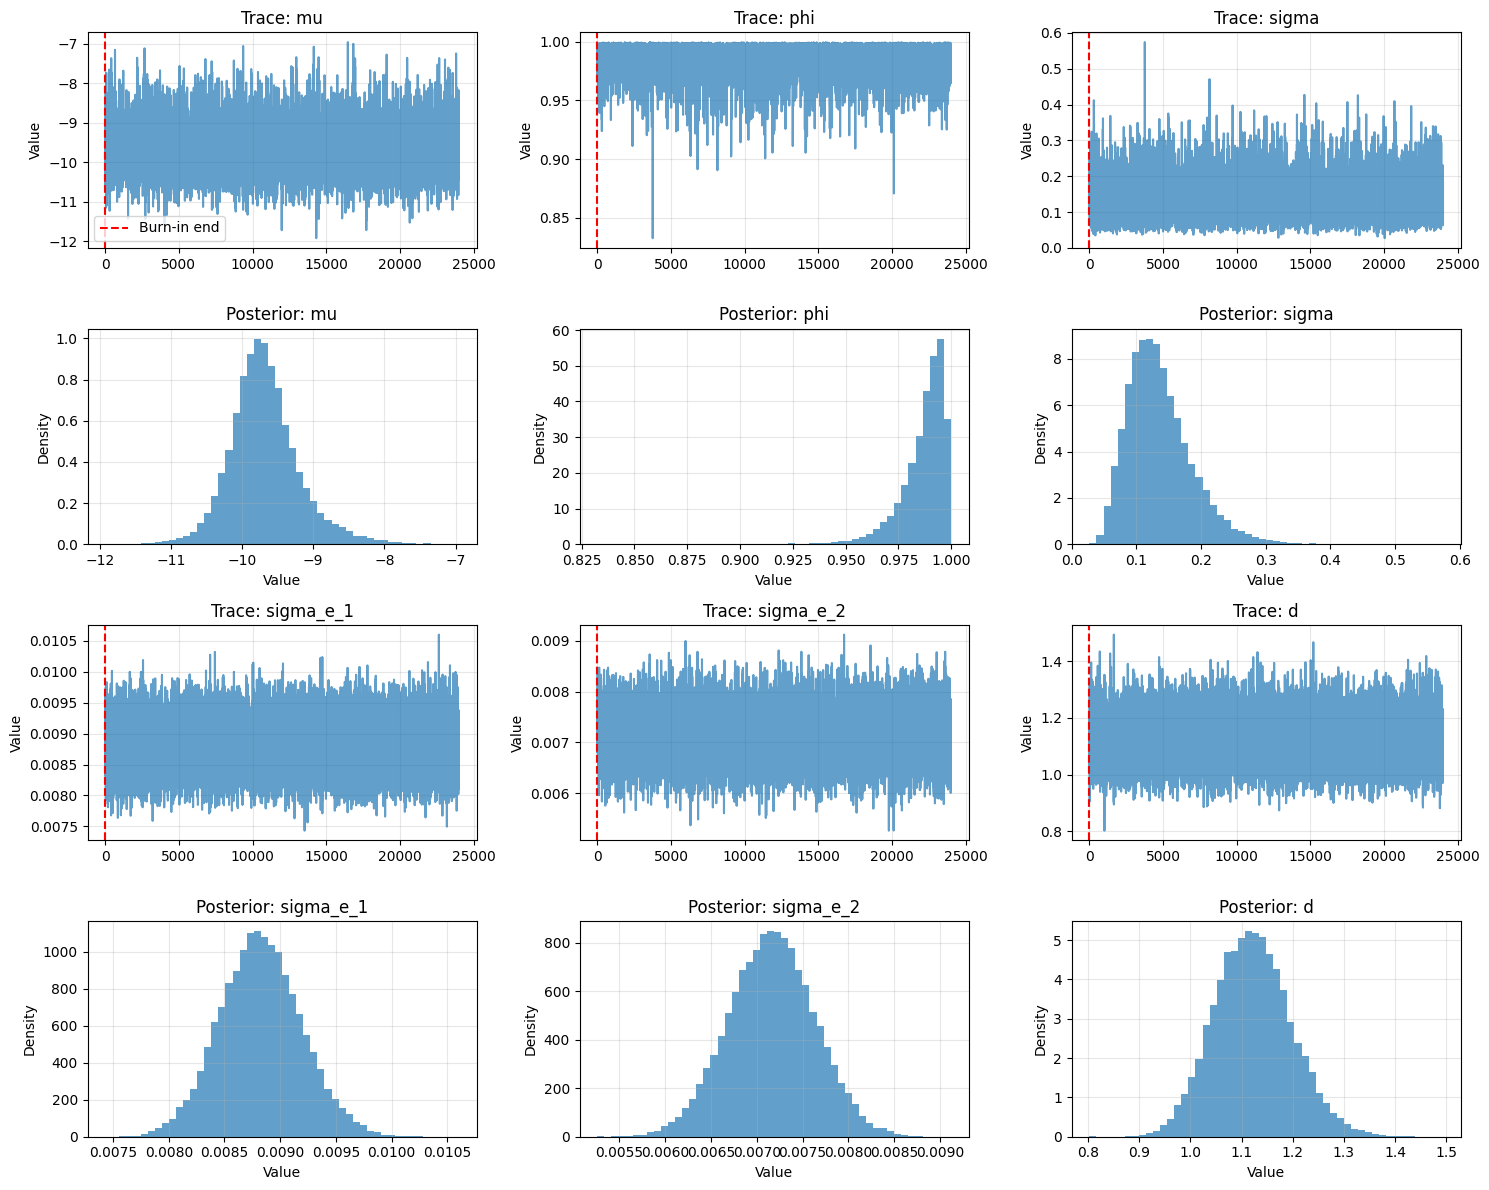

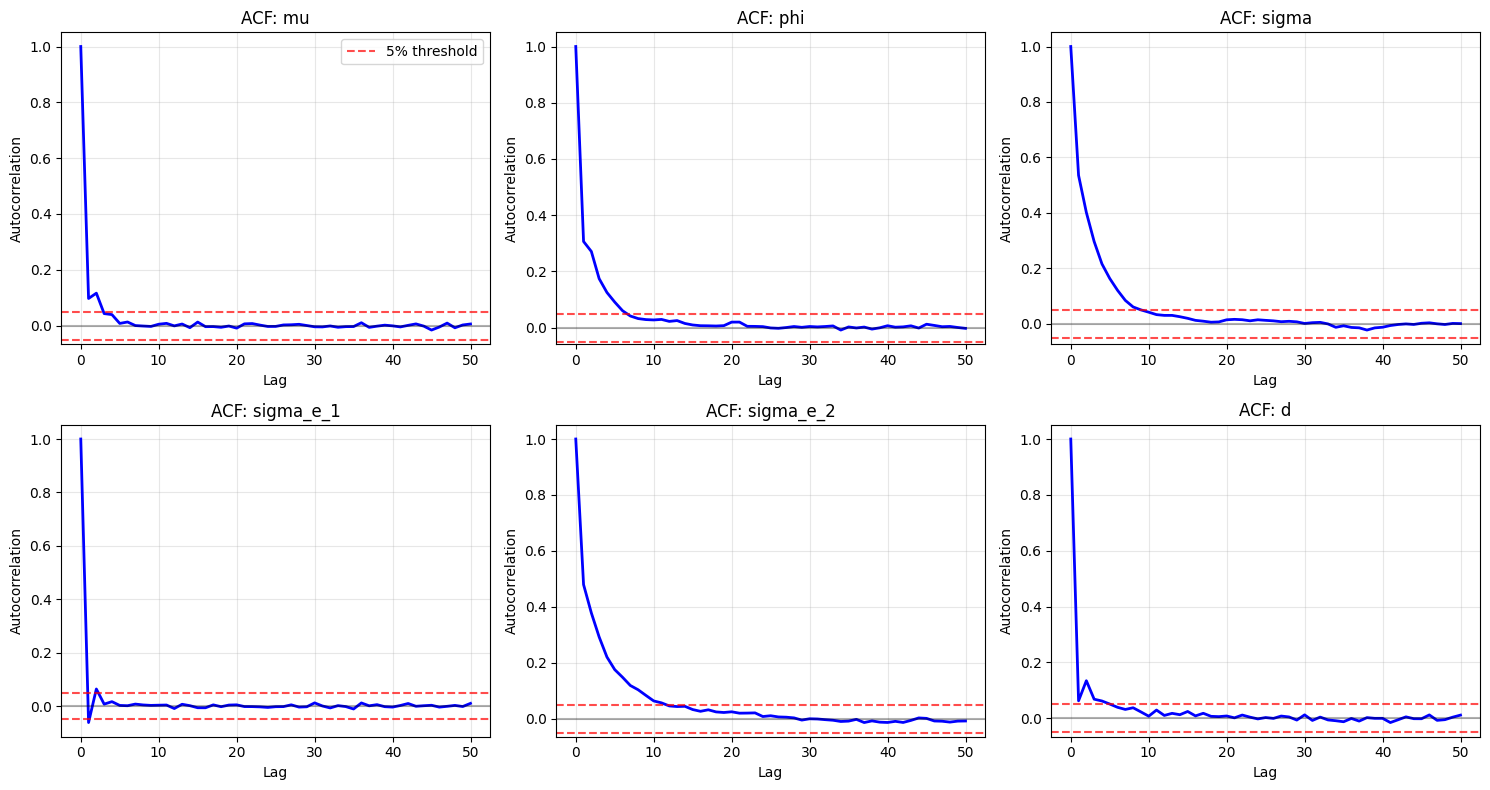


PARAMETER SUMMARY STATISTICS
------------------------------------------------------------
Parameter    Mean       Std        95% CI              
------------------------------------------------------------
mu           -9.6794    0.4961     [-10.5650, -8.5252]
phi          0.9868     0.0107     [0.9594, 0.9986]
sigma        0.1359     0.0499     [0.0608, 0.2546]
sigma_e_1    0.0088     0.0004     [0.0081, 0.0096]
sigma_e_2    0.0072     0.0005     [0.0062, 0.0081]
d            1.1223     0.0756     [0.9817, 1.2782]

ADDITIONAL DIAGNOSTICS
R-hat values not available

Diagnostics completed. Average ESS: 6110


In [77]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    n_params = len(param_names)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]
    
    for i, param in enumerate(param_names):
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF: {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()
    
    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find cutoff where autocorrelation drops below threshold
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Integrated autocorrelation time and ESS
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))
        except:
            ess_values.append(n_samples / 10)  # Conservative fallback
    
    return np.array(ess_values)

def mcmc_diagnostics_2d(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for DC_MSV model"""
    print("\nMCMC CONVERGENCE DIAGNOSTICS")
    print("=" * 50)
    
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Post-burnin samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    
    # Group parameters by type
    vol_params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2']
    corr_params = ['mu0', 'phi', 'sigma_rho']
    
    print("  Volatility parameters:")
    for param in vol_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"    {param}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")
    
    print("  Correlation parameters:")
    for param in corr_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"    {param}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")
    
    # Create trace and density plots
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    
    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        
        # Trace plot
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                                     label='Burn-in end' if i == 0 else "")
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()
        
        # Density plot
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_params, n_rows * n_cols):
        for j in [0, 1]:  # Both trace and density rows
            row = 2 * (i // n_cols) + j
            col = i % n_cols
            if row < len(axes):
                axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Plot ACF
    plot_acf(burned_chain, param_names)
    
    # Summary statistics table
    print("\nPARAMETER SUMMARY STATISTICS")
    print("-" * 60)
    print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'95% CI':<20}")
    print("-" * 60)
    
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<12} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    return ess

def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to chain format for diagnostics"""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']
    
    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)
    
    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])
    
    # NumPyro already excludes warmup
    burned_chain = chain
    return chain, burned_chain

# === RUN DIAGNOSTICS ===
print("\nRunning MCMC diagnostics...")

# Convert NumPyro results to chain format
chain, burned_chain = convert_numpyro_to_chain(results)

# Run comprehensive diagnostics
ess = mcmc_diagnostics_2d(chain, results['param_names'], burned_chain)

# NumPyro-specific diagnostics
print("\nADDITIONAL DIAGNOSTICS")
print("=" * 50)

# Try to get R-hat values
try:
    if hasattr(results['mcmc'], 'get_extra_fields'):
        r_hat = results['mcmc'].get_extra_fields().get('r_hat', {})
        if r_hat:
            print("Gelman-Rubin R-hat values:")
            for param in results['param_names']:
                if param in r_hat:
                    print(f"  {param}: {r_hat[param]:.3f}")
        else:
            print("R-hat values not available")
    else:
        print("R-hat values not available (single chain)")
except Exception as e:
    print(f"R-hat calculation error: {e}")

print(f"\nDiagnostics completed. Average ESS: {np.mean(ess):.0f}")

## 4. Model Evaluation: Out-of-Sample Performance

### Negative Log Predictive Density (NLPD) Comparison

Evaluate model performance using particle filtering on the test set to compute predictive likelihoods.

### Online Filtering and Robust Model Comparison

In [81]:
from particles_cdssm.collectors import NLPD
from scipy.stats import gaussian_kde
import numpy as np

class NLPD_Diagnostic(NLPD):
    """
    Standard NLPD with diagnostic tracking for spike analysis.
    No capping, no cooking - just honest evaluation with logging.
    """
    def __init__(self, spike_threshold=10.0, **kwargs):
        super().__init__(**kwargs)
        self.spike_threshold = spike_threshold
        self.time_step = -1  # Will be incremented to 0 on first call
        self.spike_info = []  # Store info about spikes
        
    def out_func_Y(self, wgts, Y):
        """Returns honest NLPD with diagnostic tracking."""
        if not self.has_y_true:
            return None
        
        self.time_step += 1
        
        # Standard NLPD calculation
        W = wgts.W if not self.rs_flag else None
        kde = gaussian_kde(Y.T, weights=W)
        log_p = kde.logpdf(self.y_true)
        
        if isinstance(log_p, np.ndarray):
            log_p = float(log_p.item())
            
        nlpd = -1. * log_p
        
        # Track spikes for later analysis (but don't modify the value!)
        if nlpd > self.spike_threshold:
            spike_data = {
                'time_step': self.time_step,
                'nlpd': float(nlpd),
                'observation': self.y_true.copy() if hasattr(self.y_true, 'copy') else self.y_true,
                'particle_mean': np.mean(Y, axis=0),
                'particle_std': np.std(Y, axis=0),
                'particle_min': np.min(Y, axis=0),
                'particle_max': np.max(Y, axis=0),
                'num_particles': len(Y)
            }
            self.spike_info.append(spike_data)
            
        return nlpd  # Return honest value

🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS

1. Running particle filters with 1000 particles...
   ✅ DC-MSV particle filter completed
   ✅ DC-MSV particle filter completed
   ✅ Bivariate particle filter completed

2. Extracting NLPD values from collectors...
   📊 DC-MSV raw NLPD length: 152
   📊 Bivariate raw NLPD length: 152
   ✅ Successfully extracted NLPD values
   📊 DC-MSV NLPD shape: (150,)
   📊 Bivariate NLPD shape: (150,)

🔍 SPIKE ANALYSIS FOR DC-MSV MODEL
No spikes found above threshold

📊 DETAILED SPIKE ANALYSIS
--------------------------------------------------------------------------------

3. Computing NLPD statistics...

DC-MSV Model:
  Mean NLPD:    -6.4925
  Median NLPD:  -6.8939
  Std NLPD:     1.3130
  Min/Max:      -7.47 / 0.36
  Observations: 150

Bivariate Model:
  Mean NLPD:    -6.4936
  Median NLPD:  -6.9682
  Std NLPD:     1.6233
  Min/Max:      -7.37 / 6.72
  Observations: 150

📊 MODEL COMPARISON SUMMARY:
--------------------------------------------------
Mean 

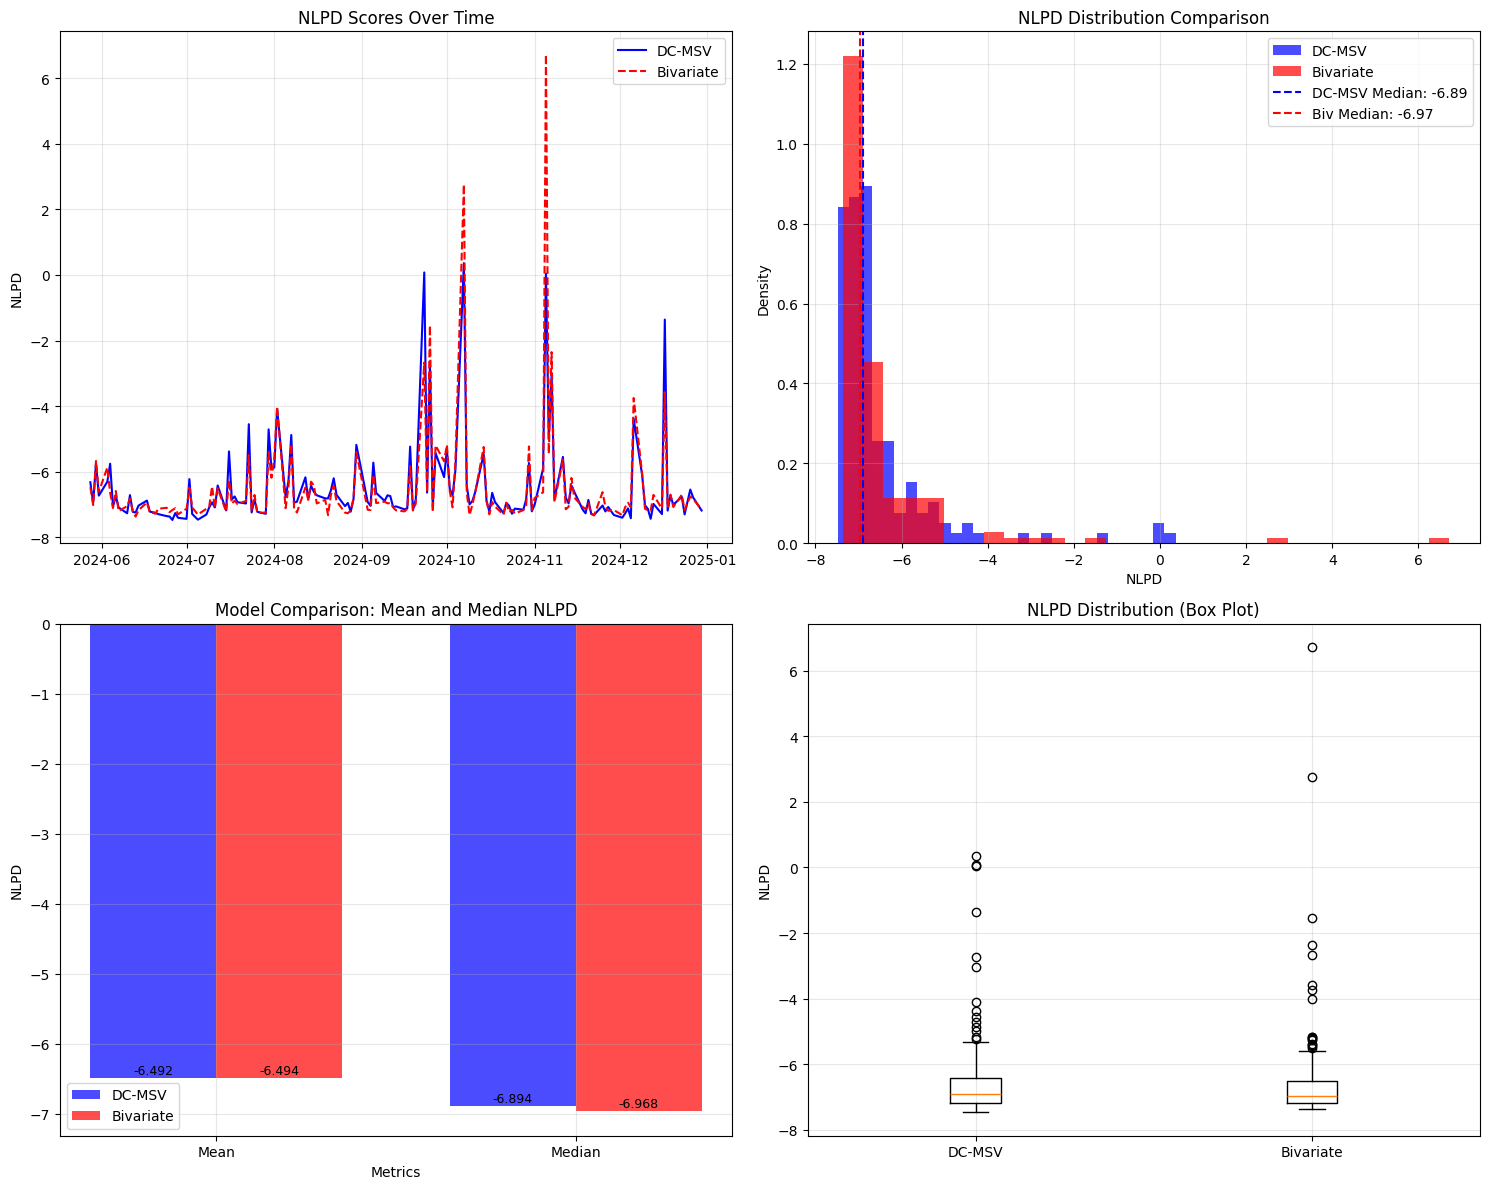

✅ NLPD comparison completed using particle predictions and collector!


In [83]:
# === NLPD COMPARISON USING PARTICLE PREDICTIONS ===
print("🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS")
print("=" * 50)

# Import missing dependencies for the model
from collections import OrderedDict
from particles import distributions as dists

# Initialize models with estimated parameters
params = results['estimates']

# Create AFactorMSV model with proper parameter initialization
afactor_model = AFactorMSV()
# Set the parameters from estimation results
afactor_model.mu = params['mu']['mean']
afactor_model.phi = params['phi']['mean']
afactor_model.sigma = params['sigma']['mean']
afactor_model.sigma_e_1 = params['sigma_e_1']['mean']
afactor_model.sigma_e_2 = params['sigma_e_2']['mean']  
afactor_model.d = params['d']['mean']

bivariate_model = BivariateNormal(train_array_decimal)

# Set up particle filters
N = 1000  # Number of particles
np.random.seed(42)  # For reproducibility

print(f"\n1. Running particle filters with {N} particles...")

# DC-MSV particle filter
fk_dc = Bootstrap(ssm=afactor_model, data=test_array_decimal)
# Use diagnostic NLPD collector for DC-MSV
nlpd_collector_dc = NLPD_Diagnostic(spike_threshold=10.0)
smc_dc = particles.SMC(fk=fk_dc, N=N, collect=[nlpd_collector_dc])
smc_dc.run()

print("   ✅ DC-MSV particle filter completed")

# Bivariate particle filter  
fk_biv = Bootstrap(ssm=bivariate_model, data=test_array_decimal)
nlpd_collector_biv = NLPD()
smc_biv = particles.SMC(fk=fk_biv, N=N, collect=[nlpd_collector_biv])
smc_biv.run()

print("   ✅ Bivariate particle filter completed")

# Extract NLPD values using the collectors
print(f"\n2. Extracting NLPD values from collectors...")

# The NLPD collector stores values as [None, array1, array2, ...] where None is at t=0
try:
    # Extract from smc summaries
    nlpd_dc_raw = smc_dc.summaries.nlpd
    nlpd_biv_raw = smc_biv.summaries.nlpd
    
    print(f"   📊 DC-MSV raw NLPD length: {len(nlpd_dc_raw)}")
    print(f"   📊 Bivariate raw NLPD length: {len(nlpd_biv_raw)}")
    
    # Convert to arrays, skipping None values and extracting scalars from arrays
    nlpd_dc_values = []
    for i, val in enumerate(nlpd_dc_raw):
        if val is not None:
            if isinstance(val, np.ndarray):
                nlpd_dc_values.append(float(val.item()))  # Extract scalar from array
            else:
                nlpd_dc_values.append(float(val))
    
    nlpd_biv_values = []
    for i, val in enumerate(nlpd_biv_raw):
        if val is not None:
            if isinstance(val, np.ndarray):
                nlpd_biv_values.append(float(val.item()))  # Extract scalar from array
            else:
                nlpd_biv_values.append(float(val))
    
    nlpd_dc_array = np.array(nlpd_dc_values)
    nlpd_biv_array = np.array(nlpd_biv_values)
    
    print(f"   ✅ Successfully extracted NLPD values")
    print(f"   📊 DC-MSV NLPD shape: {nlpd_dc_array.shape}")
    print(f"   📊 Bivariate NLPD shape: {nlpd_biv_array.shape}")
    
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    spike_threshold = 10.0
    spike_indices = np.where(nlpd_dc_array > spike_threshold)[0]

    if len(spike_indices) > 0:
        print(f"Found {len(spike_indices)} spikes with NLPD > {spike_threshold}")
        print("-" * 80)
        
        for idx in spike_indices:
            spike_date = test_df.index[idx]
            spike_value = nlpd_dc_array[idx]
            
            print(f"\nSpike at {spike_date}:")
            print(f"  NLPD value: {spike_value:.2f}")
            print(f"  Test data at this date: {test_array_decimal[idx]}")
            
            # Also show surrounding days for context
            if idx > 0:
                print(f"  Previous day NLPD: {nlpd_dc_array[idx-1]:.2f}")
            if idx < len(nlpd_dc_array) - 1:
                print(f"  Next day NLPD: {nlpd_dc_array[idx+1]:.2f}")
    else:
        print("No spikes found above threshold")
    
    # Deeper analysis of the spike
    print(f"\n📊 DETAILED SPIKE ANALYSIS")
    print("-" * 80)

    # Calculate what the model might have been expecting
    for idx in spike_indices:
        print(f"\nAnalyzing spike at index {idx} ({test_df.index[idx]}):")
        
        # Look at the data around the spike
        window = 5  # days before and after
        start_idx = max(0, idx - window)
        end_idx = min(len(test_array_decimal), idx + window + 1)
        
        print(f"\n  Returns around the spike:")
        for i in range(start_idx, end_idx):
            marker = " <-- SPIKE" if i == idx else ""
            print(f"    {test_df.index[i]}: {test_array_decimal[i]}{marker}")
        
        # Calculate correlation in surrounding window
        if idx >= 10:
            pre_spike_data = test_array_decimal[idx-10:idx]
            pre_spike_corr = np.corrcoef(pre_spike_data[:, 0], pre_spike_data[:, 1])[0, 1]
            print(f"\n  Correlation (10 days before): {pre_spike_corr:.3f}")
        
        # Look at volatilities
        if idx >= 20:
            pre_spike_vol = np.std(test_array_decimal[idx-20:idx], axis=0)
            print(f"  Volatilities (20 days before): {pre_spike_vol}")
            print(f"  Actual returns at spike: {test_array_decimal[idx]}")
            print(f"  Standardized returns: {test_array_decimal[idx] / pre_spike_vol}")
    
    if len(nlpd_dc_array) == 0 or len(nlpd_biv_array) == 0:
        raise ValueError("No valid NLPD values extracted")
        
except Exception as e:
    print(f"   ❌ Error extracting NLPD: {e}")
    print("   🚨 Cannot proceed with NLPD comparison")
    raise

# After extracting NLPD values but before computing statistics
if hasattr(nlpd_collector_dc, 'spike_info') and len(nlpd_collector_dc.spike_info) > 0:
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    print(f"Found {len(nlpd_collector_dc.spike_info)} spikes with NLPD > 10")
    print("-" * 80)
    
    for i, spike in enumerate(nlpd_collector_dc.spike_info):
        # Convert time_step to actual date
        spike_date = test_df.index[spike['time_step']]
        
        print(f"\nSpike {i+1} at {spike_date}:")
        print(f"  NLPD value: {spike['nlpd']:.2f}")
        print(f"  Observed values: {spike['observation']}")
        print(f"  Particle mean: {spike['particle_mean']}")
        print(f"  Particle std: {spike['particle_std']}")
        print(f"  Particle range: [{spike['particle_min']}, {spike['particle_max']}]")
        
        # Show how far the observation was from particle predictions
        z_scores = (spike['observation'] - spike['particle_mean']) / spike['particle_std']
        print(f"  Z-scores: {z_scores}")

# Compute statistics
print(f"\n3. Computing NLPD statistics...")

# DC-MSV statistics
stats_dc = {
    'mean': np.mean(nlpd_dc_array),
    'std': np.std(nlpd_dc_array),
    'median': np.median(nlpd_dc_array),
    'min': np.min(nlpd_dc_array),
    'max': np.max(nlpd_dc_array),
    'n_obs': len(nlpd_dc_array)
}

# Bivariate statistics
stats_biv = {
    'mean': np.mean(nlpd_biv_array),
    'std': np.std(nlpd_biv_array),
    'median': np.median(nlpd_biv_array),
    'min': np.min(nlpd_biv_array),
    'max': np.max(nlpd_biv_array),
    'n_obs': len(nlpd_biv_array)
}

print(f"\nDC-MSV Model:")
print(f"  Mean NLPD:    {stats_dc['mean']:.4f}")
print(f"  Median NLPD:  {stats_dc['median']:.4f}")
print(f"  Std NLPD:     {stats_dc['std']:.4f}")
print(f"  Min/Max:      {stats_dc['min']:.2f} / {stats_dc['max']:.2f}")
print(f"  Observations: {stats_dc['n_obs']}")

print(f"\nBivariate Model:")
print(f"  Mean NLPD:    {stats_biv['mean']:.4f}")
print(f"  Median NLPD:  {stats_biv['median']:.4f}")
print(f"  Std NLPD:     {stats_biv['std']:.4f}")
print(f"  Min/Max:      {stats_biv['min']:.2f} / {stats_biv['max']:.2f}")
print(f"  Observations: {stats_biv['n_obs']}")

# Model comparison
mean_diff = stats_dc['mean'] - stats_biv['mean']
median_diff = stats_dc['median'] - stats_biv['median']

print(f"\n📊 MODEL COMPARISON SUMMARY:")
print("-" * 50)
print(f"Mean NLPD Difference (DC-MSV - Bivariate): {mean_diff:.4f}")
print(f"Median NLPD Difference:                    {median_diff:.4f}")

if mean_diff < 0:
    print(f"✅ DC-MSV performs better by {abs(mean_diff):.4f} NLPD points")
else:
    print(f"❌ Bivariate performs better by {mean_diff:.4f} NLPD points")

# Visualization
print(f"\n4. Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Time series comparison
dates = test_df.index[:len(nlpd_dc_array)]
axes[0,0].plot(dates, nlpd_dc_array, label='DC-MSV', color='blue', linewidth=1.5)
axes[0,0].plot(dates, nlpd_biv_array, label='Bivariate', color='red', linestyle='--', linewidth=1.5)
axes[0,0].set_title('NLPD Scores Over Time')
axes[0,0].set_ylabel('NLPD')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Histogram comparison
axes[0,1].hist(nlpd_dc_array, bins=30, alpha=0.7, color='blue', density=True, label='DC-MSV')
axes[0,1].hist(nlpd_biv_array, bins=30, alpha=0.7, color='red', density=True, label='Bivariate')
axes[0,1].axvline(stats_dc['median'], color='blue', linestyle='--', label=f'DC-MSV Median: {stats_dc["median"]:.2f}')
axes[0,1].axvline(stats_biv['median'], color='red', linestyle='--', label=f'Biv Median: {stats_biv["median"]:.2f}')
axes[0,1].set_title('NLPD Distribution Comparison')
axes[0,1].set_xlabel('NLPD')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Bar chart comparison
metrics = ['Mean', 'Median']
dc_values = [stats_dc['mean'], stats_dc['median']]
biv_values = [stats_biv['mean'], stats_biv['median']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, dc_values, width, label='DC-MSV', color='blue', alpha=0.7)
bars2 = axes[1,0].bar(x + width/2, biv_values, width, label='Bivariate', color='red', alpha=0.7)

axes[1,0].set_xlabel('Metrics')
axes[1,0].set_ylabel('NLPD')
axes[1,0].set_title('Model Comparison: Mean and Median NLPD')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Box plot comparison
axes[1,1].boxplot([nlpd_dc_array, nlpd_biv_array], labels=['DC-MSV', 'Bivariate'])
axes[1,1].set_title('NLPD Distribution (Box Plot)')
axes[1,1].set_ylabel('NLPD')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ NLPD comparison completed using particle predictions and collector!")